# Old School RuneScape Time-To-Kill Calculations

In [156]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from abc import ABC, abstractmethod
from dataclasses import dataclass
import math

TODO: Introduction

- Time-to-kill: DPS is not everything if you're speedrunning
  - Can ignore delay imposed on last hit
  - Overkill
  - Optimizing for potential, not average performance

Damage in OSRS is calculated using a two-step process. The first step is the accuracy roll: we sample from a Bernoulli distribution with parameter $p$. If the value is 0, the attack misses and the damage is 0. If the roll is successfull, the damage is sampled from $U[0, d_\textrm{max}]$, where $d_\textrm{max}$ is the max hit of the weapon.

In [157]:
class SingleHit:
    def __init__(self, prob_hit: float, max_hit: int):
        self.prob_hit = prob_hit
        self.max_hit = max_hit
    
    def support(self):
        return range(0, self.max_hit + 1)

    def prob(self, damage):
        if not 0 <= damage <= self.max_hit:
            return 0

        p_hit = self.prob_hit / (self.max_hit + 1)

        # Two ways of rolling a zero: fail accuracy roll or pass accuracy roll and roll a 0.
        if damage == 0:
            return (1 - self.prob_hit) + p_hit

        return p_hit

For scythes, the single-hitsplat logic is repeated three times. They share the same accuracy but have different max values. One hit is at full power, one at half of that and one at 0.25 times the full power, rounded down. The hits are independent. Using this we can compute the distribution for the total damage done by a scythe swing as a convolution.

In [158]:
class Convolution:
    def __init__(self, u, v):
        self.u = u
        self.v = v
 
    def support(self):
        return range(self.u.support()[0] + self.v.support()[0], self.u.support()[-1] + self.v.support()[-1] + 1)

    @functools.lru_cache(maxsize=None)
    def prob(self, x: int):
        return sum([self.u.prob(i) * self.v.prob(x - i) for i in self.u.support()])

    @staticmethod
    def convolve_all(*distributions):
        assert len(distributions) >= 2

        convolved = distributions[0]

        for distribution in distributions[1:]:
            convolved = Convolution(convolved, distribution)
            
        return convolved

We now move on to defining parameters for the toxic blowpipe and the scythe, using fairly standard inferno speedrunning setups. We also define a ranger (Jal-Xil) as a target because they seem to have the funkiest strategies.

In [167]:
MOB_HEALTH = 130

SCYTHE_ACC = 0.9398
SCYTHE_MAX = 51

PIPE_ACC = 0.9461
PIPE_MAX = 35

scythe = Convolution.convolve_all(
    SingleHit(SCYTHE_ACC, SCYTHE_MAX),
    SingleHit(SCYTHE_ACC, int(0.5 * SCYTHE_MAX)),
    SingleHit(SCYTHE_ACC, int(0.25 * SCYTHE_MAX)),
)

pipe = SingleHit(PIPE_ACC, PIPE_MAX)

weapons = [(pipe, 2), (scythe, 5)]

The time to kill satisfies the recursive equation
$$\textrm{ttk}[x] = \mathbb{E}\left[ c(H) + \textrm{ttk}[\max(x - H, 0)] \right]$$
where
$$c(h) = \begin{cases} 
    0 & \textrm{if } x - h \leq 0 \\
    t & \textrm{otherwise.}
\end{cases}$$

This cost definition is crucial for interesting strategies to emerge. We are not interested in the cooldown duration after the last mob is killed, because this time is spent waiting in-between waves anwyay.

Implementing this directly using recursive dynamic programming is problematic because we can transition back to the current problem in the case where we hit a zero. We can work around this by expanding the expectation and rearranging as
$$\textrm{ttk}[x] = P(H = 0) \textrm{ttk}[x] + \sum_{h=1}^{h_\textrm{max}} P(H = h) c(x - h) $$
Here, as long as $P(H = 0) > 0$, in each state we have an $P(H = 0)$-contraction in $\mathbb{R}$. We can use this formula as an iterative update rule (similar to value iteration, but with only a single state) or solve it directly. To solve it directly, we see that $x = \alpha x + c \Rightarrow x = \frac{c}{1-\alpha}$. Thus, we can compute the sum and then handle the self-recurrence by adding a correction term.

In [169]:
time_to_kill = [math.inf for i in range(MOB_HEALTH + 1)]
best_weapon = [None for i in range(MOB_HEALTH + 1)]

time_to_kill[0] = 0

for hp in range(1, MOB_HEALTH + 1):
    for i, (dist, delay) in enumerate(weapons):
        value = 0

        for hit in dist.support()[1:]:
            value += dist.prob(hit) * ((delay if hp - hit > 0 else 0) + time_to_kill[max(hp - hit, 0)])

        value = (value + delay * dist.prob(0)) / (1 - dist.prob(0))
            
        if value < time_to_kill[hp]:
            time_to_kill[hp] = value
            best_weapon[hp] = i

print(time_to_kill[-1])
print(best_weapon)

13.486017909130018
[None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


We see that the time to kill using optimal switching is approximately 13.49 ticks and that the strategy consists of piping first and then scything. Other armour leads to strategies such as scything, piping, then scything again.

This is the average time-to-kill. The underlying distribution is called a phase-type distribution. Statisticians fool around with matrices to compute those but I found that an absolutely miserable endeavour. It probably makes sense in some cases but we have a very structured problem where there are self-loops but no loops back to a higher hitpoint, which allows us to continue with simple dynamic programming.

We have a similar recurrence for the probability of the TTK being a certain value.

I should also explain this.

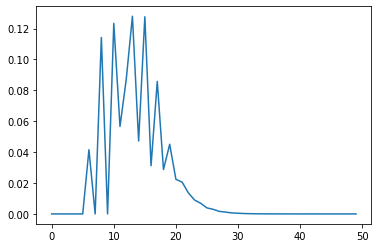

In [171]:
@functools.lru_cache(maxsize=None)
def p(ttk, hp):
    if hp <= 0:
        return 0

    if ttk < 0:
        return 0

    dist, delay = weapons[best_weapon[hp]]

    if ttk == 0:
        return sum(dist.prob(hit) if hp - hit <= 0 else 0 for hit in dist.support())

    return sum(dist.prob(hit) * p(ttk - delay, hp - hit) for hit in dist.support())

x_values = range(50)
y_values = [p(x, MOB_HEALTH) for x in x_values]
plt.plot(x_values, y_values)

Another interesting problem is to consider other optimization problems than average time-to-kill. For example, we might want to maximize our chance of breaking the world-record speedrun of some boss using intricate weapon selections.

We can solve this using dynamic programming by giving a reward of 1 for breaking the target and 0 otherwise. Solving this MDP using dynamic programming yields a policy which maximizes the expected reward, i.e. maximizing the probability of making the cutoff.

Note that in this case we need a non-stationary policy - one that depends on the amount of time the agent has left to make the cutoff.

In [174]:
target_ticks = 10

reward = [[0 for j in range(target_ticks + 1)] for i in range(MOB_HEALTH + 1)]
best_weapon = [[None for j in range(target_ticks + 1)] for i in range(MOB_HEALTH + 1)]

for hp in range(1, MOB_HEALTH + 1):
    for remaining_ticks in range(1, target_ticks + 1):
        for i, (dist, delay) in enumerate(weapons):
            value = 0

            for hit in dist.support():
                value += dist.prob(hit) * ((1 if hp - hit == 0 else 0) + reward[max(hp - hit, 0)][max(remaining_ticks - delay, 0)])        
                
            if value > reward[hp][remaining_ticks]:
                reward[hp][remaining_ticks] = value
                best_weapon[hp][remaining_ticks] = i
                
print(best_weapon)

[[None, None, None, None, None, None, None, None, None, None, None], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [None, 0, 0, 0, 0, 

TODO - Visualise this policy